In [ ]:
!python --version

### TODO

* ~Try a built-in optimizer (like grad descent w/ momentum) instead of constant learning rate. See how convergence time changes~
* ~Plot loss~
* ~Refactor (processors are modules)~
* ~Define `init_params` methods for each processor, initializing to params that have no effect on the signal (no-op  prior)~
  - this is something to note in writeup. talk about small changes to params having big effect in processors with feedback. And how starting from no effect initially is good for live performance settings.
* ~Add a simple clipping nonlinearity effect to see how `grad` does with that~
* ~Refactoring~
  - ~Use dicts for labeled params instead of n-d arrays (jax handles this)~
  - ~Move parameter label creation into processor fns~
* ~Estimate params for multiple serially-connected filters (create a general `serial_processors` processor)~
* ~~Run on GPU & measure performance differences~~
  - ~~Performance is indeed much better on a GPU, despite the serial bottlneck of the IIR filters.~~
  - ~~E.g. for a length-5 IIR filter with an input sequence of length 300, on a GPU:
    `CPU times: user 14.6 s, sys: 664 ms, total: 15.3 s, Wall time: 15.7 s`.
    On the CPU, it wouldn't even finish for more than 5 minutes so I stopped it and dropped the input length to 100, and got these numbers; `CPU times: user 37.1 s, sys: 816 ms, total: 38 s, Wall time: 37.7 s`~~
* ~~Add `tick_buffer` methods to all processors, which will allow for fast convolution FIR implementations and use of `lax.scan`~~
* ~~How to speed up IIR filters (like allpass filters)?~~ This is basically completely resolved with the current `lax.scan`-based implementation!
* ~~Use minibatches instead of just a single unit impulse signal. See if it finds parameters closer to ground truth.~~
  - Done - averaging gradients over minibatches doesn't seem to have a big effect on accuracy. But it's good to have this in place and using `vmap` to vectorize across multiple training pairs provides some speedup
* ~~Try different optimizers, learning rates, gradient clipping, and any other techniques to guide to better parameter spaces for IIR filters (always wants to over-compensate with a large a[0] parameter to scale the full output)~~
  - Eh, I tried a few optimizers, learning rates, tried weight norm clipping. I ultimately just stopped optimizing the output gain param in the IIR filter (`a[0]`) since it's not commonly used anyway.
* Add a `DelayLine` processor. This is fundamentally a FIR filter, with the important difference that it's only parameterized by a couple params (like delay length and dry/wet level), rather than one param for each coefficient. The single-sample `tick` method can show off the ability to implement in the more traditional read/write pointer style as well.
  - Having a lot of trouble finding a way to find a gradient on a parameter that controls delay length, since the gradient "gets lost". Lots more details in the "Differentiable array indexing" notebook.
  - ~~Investigate [variable_length_delay DDSP effect](https://github.com/magenta/ddsp/blob/master/ddsp/core.py#L1009-L1037) & usage. They take a different approach - might find some inspiration.~~
    * Welp, they only implement a _feed-forward_ delay. My goal here is a feedback delay. Still, I'm having the same issue with my FF delay, so there might be something about their parameterization or technique that I can learn from.
  - ~~Plot optimization for different starting guesses, to help get a sense of why the gradient is blocked outside the +/- 1 range from initial delay-length param to target.~~
* Add `AllpassFilter` and `CombFilter` processors
* Test on a realistic 4-second audio signal at 24kHz
* Animate changes in output signal over time, compared with target
* Use a perceptual loss function instead of mse (steal DDSP's multi-scale spectral loss fn)
* Improve performance
  - ~Speed things up with [JIT](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#Using-jit-to-speed-up-functions)~
  - What if we estimate parameters without running across the full input sample? Like just test against a very small input sample? E.g. a length-5 IIR filter shouldn't need to backprop against every sample of a 2-second clip. That's just super redundant, right? Its behavior should be fully determinable from an input sample of a length on the order of the coefficients I think. This could generalize to other processors as well. (Maybe something like a `testLength` for each processor.) Should be able to test this well by comparing loss as `testLength` drops.
* ~I don't think functions truly need to be pure. I tried passing in a plain np array and changing it in place and it seemed to work fine. Maybe we can use shared buffers to improve memory usage?~
  - Answer - this is because you can create and use state _inside_ functions transformed by JAX. I found a decent middleground here that lets me use processor classes with internal state by instantiating them inside the transformed fn.
* End-goal (ready for blog post): [Implement freeverb and perform dereverbing](https://trello.com/c/NSnb806w/2-goal-parameterize-freeverb)
  - Implement [Lowpass Feedback Comb Filter](https://ccrma.stanford.edu/~jos/pasp/Lowpass_Feedback_Comb_Filter.html) as pure IIR filter(s)
* Most similar paper: [Differentiable IIR Filters for Machine Learning Applications (2020)](https://www.dafx.de/paper-archive/details.php?id=rA_6fTdLky8YDvH03jdufw)
  - Replicate their Boss DS-1 pedal experiment and compare

In [1]:
import jax.numpy as jnp
from scipy import signal
import numpy as np
import time

import sys
sys.path.append('./')

sys.path.append('./processors')
import fir_filter, iir_filter, clip, delay_line, iir_delay, index_update, feedforward_delay, serial_processors
from plotters import plot_filter, plot_loss, plot_params, plot_optimization
from train import train, evaluate, process

In [2]:
def array_with_one_at(i, size):
    ar = np.zeros(size)
    ar[i] = 1.0
    return ar

In [3]:
n_batches = 1_000
batch_size = 8
n_train = 200
samples_per_second = 44_100
n_samples = 200 # 4 * samples_per_second
Xs_random = np.random.randn(n_train, n_samples)
Xs_unit = np.array([array_with_one_at(i, n_samples) for i in range(n_train)])
#Xs_chirp = np.array(np.split(signal.chirp(np.linspace(0, 10, n_train * n_samples), f0=300, f1=1, t1=10), n_train))
Xs_chirp = np.ones((n_train,1)) * signal.chirp(np.linspace(0, 10, n_samples), f0=10, f1=1, t1=10)

In [4]:
def evaluate_processors(processors, Xs=Xs_chirp, reference_fn=None,
                        plot_loss_history=True, plot_params_history=True):
    start = time.time()
    params_estimated, params_target, params_history, loss_history = train(processors, Xs, num_batches=n_batches, batch_size=batch_size)
    print('Train time: {:.3E} s'.format(time.time() - start))
    X_eval = Xs[0]
    Y_estimated, Y_target = evaluate(params_estimated, params_target, serial_processors, X_eval, processors)
    Y_reference = reference_fn(X_eval, params_target) if reference_fn is not None else None

    print(params_estimated)
    if plot_loss_history:
        plot_loss(loss_history)
    if plot_params_history:
        plot_params(params_target, params_history)
    title = ' + '.join(processor.NAME for processor in processors)
    plot_filter(X_eval, Y_target, Y_reference, Y_estimated, title)

Train time: 2.328E+00 s
{'Feedforward Delay': {'delay_samples': DeviceArray(5.9994807, dtype=float32), 'wet_amount': DeviceArray(0.49779686, dtype=float32)}}


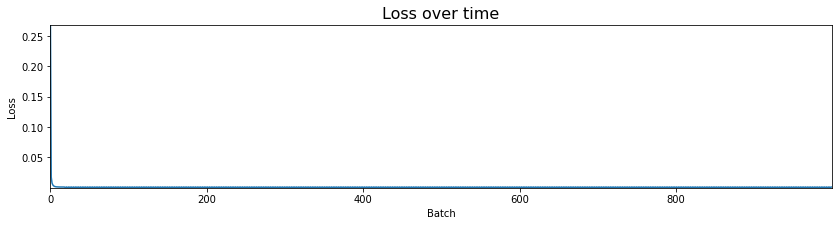

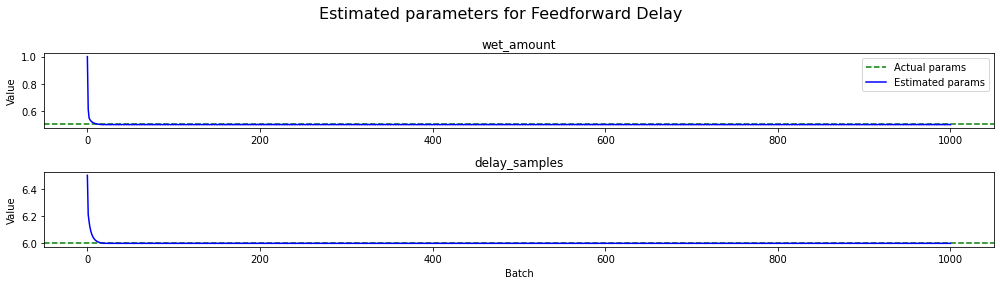

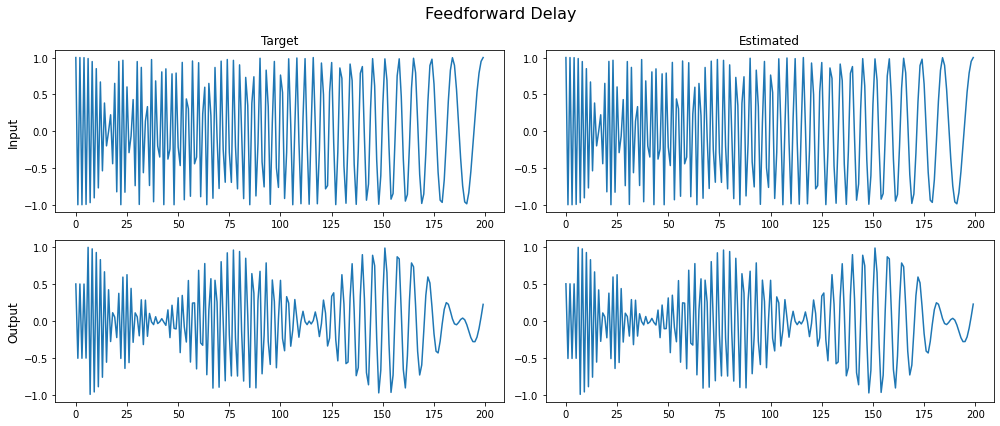

In [5]:
evaluate_processors([feedforward_delay])

In [ ]:
evaluate_processors([delay_line])

In [ ]:
evaluate_processors([iir_delay])

In [ ]:
evaluate_processors([fir_filter], reference_fn=lambda X, params: signal.lfilter(params[fir_filter.NAME]['B'], [1.0], X))

In [ ]:
evaluate_processors([iir_filter], reference_fn=lambda X, params: signal.lfilter(params[iir_filter.NAME]['B'], params[iir_filter.NAME]['A'], X), plot_params_history=False)

In [ ]:
evaluate_processors([clip], reference_fn=lambda X, params: np.clip(X, params[clip.NAME]['min'], params[clip.NAME]['max']))

In [ ]:
evaluate_processors([iir_filter, clip])

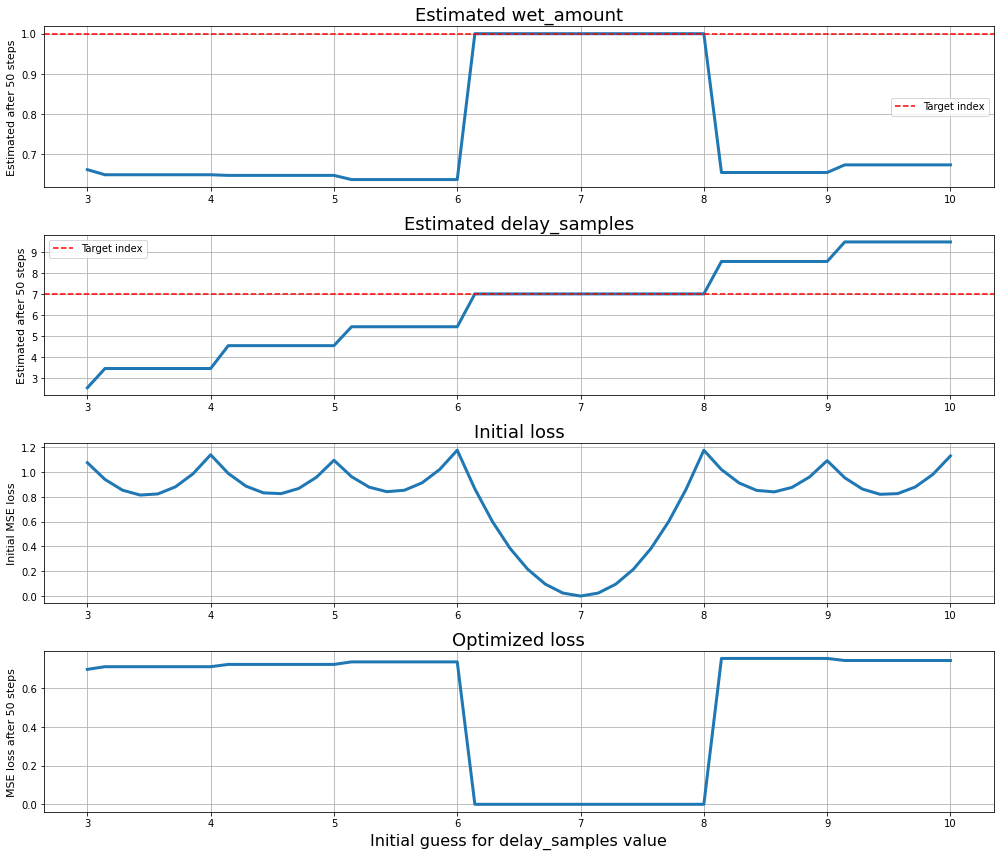

In [26]:
param_inits = [{'delay_samples': delay_samples, 'wet_amount': 1.0} for delay_samples in np.linspace(3, 10, 50)]
params_target = {'wet_amount': 1.0, 'delay_samples': 7.0}
plot_optimization(delay_line, Xs_chirp, param_inits, params_target)

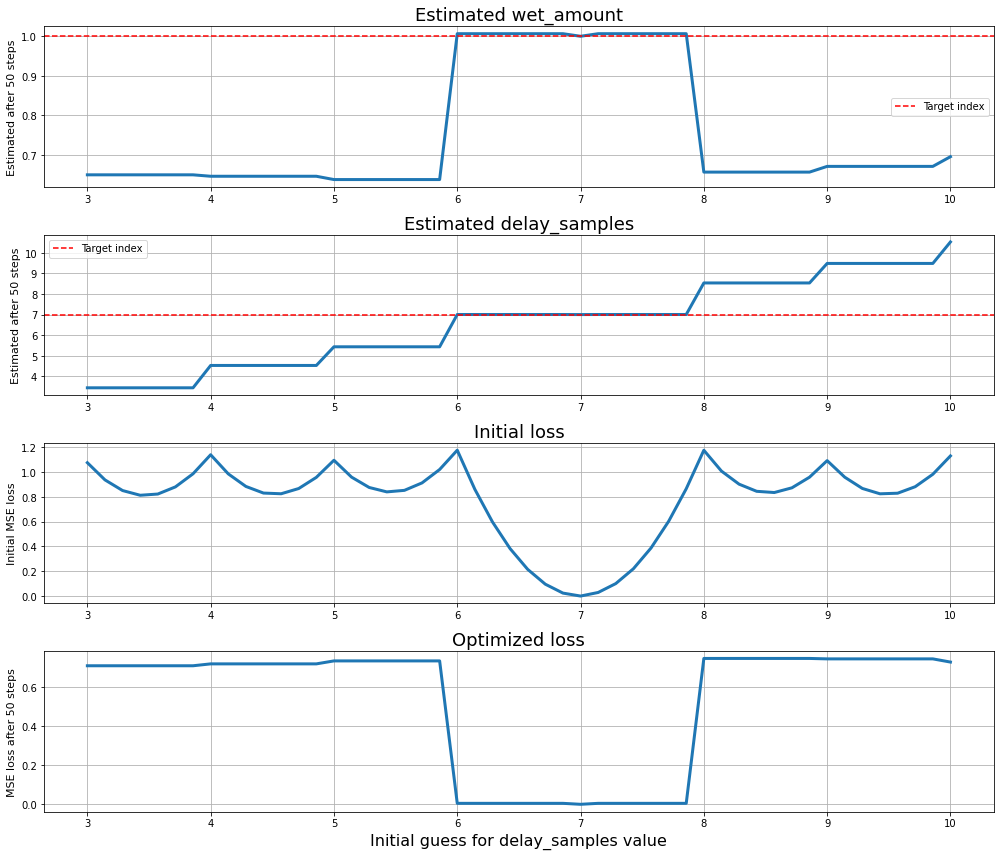

In [27]:
param_inits = [{'delay_samples': delay_samples, 'wet_amount': 1.0} for delay_samples in np.linspace(3, 10, 50)]
params_target = {'wet_amount': 1.0, 'delay_samples': 7.0}
plot_optimization(feedforward_delay, Xs_chirp, param_inits, params_target)